# K-nearest Neighbors

Ejemplo de clasificación con KNN con sklearn

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from feature_engine.encoding import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, PredefinedSplit

In [18]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [19]:
%watermark -v -p "pandas,matplotlib,sklearn,feature_engine"

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.12.0

pandas        : 1.3.5
matplotlib    : 3.1.3
sklearn       : 1.0.2
feature_engine: 1.4.0



## Datos

Usamos el dataset `penguins` de seaborn creado por [Allison Horst](https://github.com/allisonhorst/palmerpenguins#about-the-data).

In [20]:
df = sns.load_dataset("penguins")

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


Por simplicidad, eliminamos los registros con datos faltantes. 

**OJO** en un caso real hay que evaluar esto con cuidado! 

In [22]:
df = df.dropna()

In [23]:
df['species'].value_counts()

Adelie       146
Gentoo       119
Chinstrap     68
Name: species, dtype: int64

Separamos los datos en features y target.

In [24]:
X = df.drop(columns=['species'])
y = df['species']

Particionamos los datos en training y validation.

Estamos asumiendo que previamente hicimos una partición en train y test. Es decir, la partición final se ve así:

<img src="train_val_test.png">

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=33)

## Modelo

### Entrenamiento 

Vamos a usar pipelines de sklearn y la librería feature-engine para _entrenar_ el preprocesamiento y el modelo. Vamos a ver más en detalle estas herramientas en la próxima clase :)

In [26]:
X_train.head(6)

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
313,Biscoe,49.5,16.1,224.0,5650.0,MALE
236,Biscoe,42.0,13.5,210.0,4150.0,FEMALE
284,Biscoe,45.8,14.2,219.0,4700.0,FEMALE
22,Biscoe,35.9,19.2,189.0,3800.0,FEMALE
140,Dream,40.2,17.1,193.0,3400.0,FEMALE
93,Dream,39.6,18.1,186.0,4450.0,MALE


¿Qué transformaciones necesitamos aplicar para poder usar KNN?

In [27]:
X_train["island"].value_counts()

Biscoe       118
Dream         93
Torgersen     38
Name: island, dtype: int64

In [28]:
X_train["sex"].value_counts()

MALE      133
FEMALE    116
Name: sex, dtype: int64

Vamos a: 

1. convertir las variables categóricas en numéricas
2. normalizar todas las variables numéricas (luego de 1 todas son numéricas)

In [29]:
all_features = X.columns.tolist()
categorical_features = [c for c in all_features if X_train[c].dtype == 'object']
numeric_features = [c for c in all_features if X_train[c].dtype != 'object']

print(categorical_features)
print(numeric_features)
print(all_features)

['island', 'sex']
['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
['island', 'bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']


In [32]:
pipe = Pipeline([
    ("cat_encoder", OneHotEncoder(variables=categorical_features)),
    ("scaler", MinMaxScaler()),
    ("clf", KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='manhattan')),
])

In [33]:
pipe

Pipeline(steps=[('cat_encoder', OneHotEncoder(variables=['island', 'sex'])),
                ('scaler', MinMaxScaler()),
                ('clf', KNeighborsClassifier(metric='manhattan'))])

Los pipelines y modelos de sklearn tienen tres métodos principales: `fit`, `transform` y `predict`.

* `fit` entrena las transformaciones y el modelo
  * las normalizaciones, por ejemplo, son transformaciones que se "entrenan" porque se calcular con los datos de entrenamiento, y luego se aplican a los datos de validación y test
* `transform` aplica las transformaciones
* `predict` predice con el modelo entrenado

minmax(x0) = (x0 - min(x_train)) / (max(x_train) - min(x_train))

In [34]:
# entrenamos todo el pipeline
_ = pipe.fit(X_train, y_train)

In [35]:
pipe.named_steps

{'cat_encoder': OneHotEncoder(variables=['island', 'sex']),
 'scaler': MinMaxScaler(),
 'clf': KNeighborsClassifier(metric='manhattan')}

In [41]:
# los estadisticos usados en el scaler:
pipe.named_steps.scaler.data_min_, pipe.named_steps.scaler.data_max_

(array([  33.1,   13.1,  172. , 2700. ,    0. ,    0. ,    0. ,    0. ,
           0. ]),
 array([5.96e+01, 2.15e+01, 2.31e+02, 6.30e+03, 1.00e+00, 1.00e+00,
        1.00e+00, 1.00e+00, 1.00e+00]))

In [38]:
# si aplicamos todos los pasos menos el modelo, obtenemos los datos transformados:
pipe[:-1].transform(X_train)

array([[0.61886792, 0.35714286, 0.88135593, ..., 0.        , 1.        ,
        0.        ],
       [0.33584906, 0.04761905, 0.6440678 , ..., 0.        , 0.        ,
        1.        ],
       [0.47924528, 0.13095238, 0.79661017, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.24528302, 0.48809524, 0.40677966, ..., 1.        , 0.        ,
        1.        ],
       [0.58867925, 0.11904762, 0.6440678 , ..., 0.        , 0.        ,
        1.        ],
       [0.08301887, 0.69047619, 0.25423729, ..., 0.        , 0.        ,
        1.        ]])

In [39]:
# con estos nombres de columnas:
pipe[:-1].get_feature_names_out()

array(['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm',
       'body_mass_g', 'island_Biscoe', 'island_Dream', 'island_Torgersen',
       'sex_MALE', 'sex_FEMALE'], dtype=object)

In [21]:
# cualquier categoria nueva que no se haya visto en el set de entrenamiento, 
# se codifica como un 0 en todas las columnas:
pipe.named_steps.cat_encoder.encoder_dict_

{'island': ['Biscoe', 'Dream', 'Torgersen'], 'sex': ['MALE', 'FEMALE']}

In [40]:
# podemos aplicar las transformaciones a nuevos datos:
pipe[:-1].transform(X_val)

array([[ 0.6       ,  0.77380952,  0.6779661 ,  0.44444444,  0.        ,
         1.        ,  0.        ,  1.        ,  0.        ],
       [ 0.45283019,  0.1547619 ,  0.6440678 ,  0.47222222,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.24150943,  0.51190476,  0.23728814,  0.30555556,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ],
       [ 0.54339623,  0.10714286,  0.6779661 ,  0.60416667,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.50943396,  0.13095238,  0.6440678 ,  0.59722222,  1.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [ 0.10566038,  0.41666667,  0.30508475,  0.09722222,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ],
       [ 0.4490566 ,  0.27380952,  0.81355932,  0.65277778,  1.        ,
         0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.30188679,  0.5952381 ,  0.55932203,  0.44444444,  0

### Predict

Usamos el pipeline entrenado para predecir sobre los datos de validación.

In [42]:
y_val_pred = pipe.predict(X_val)

In [43]:
print(y_val_pred[:5])
print(y_val[:5])

['Chinstrap' 'Gentoo' 'Adelie' 'Gentoo' 'Gentoo']
199    Chinstrap
272       Gentoo
1         Adelie
308       Gentoo
270       Gentoo
Name: species, dtype: object


seguir desde acá!

In [44]:
accuracy_score(y_val, y_val_pred)

1.0

In [26]:
print(confusion_matrix(y_val, y_val_pred))

[[31  0  0]
 [ 0 18  0]
 [ 0  0 35]]


In [27]:
# el modelo es perfecto! :o

### Ajuste de hiperparámetros

Supongamos que hacemos _grid search_ de hiperparámetros del modelo; es decir, entrenamos el modelo con distintas configuraciones y evaluamos el desempeño de cada una en el conjunto de validación.

Usamos un único corte train-validation.

In [28]:
# que parametros del clasificador podemos modificar?
pipe.named_steps.clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [29]:
# usamos la convencion de __ para acceder a los parametros de los pasos del pipeline:
param_grid = {
    "clf__n_neighbors": range(1, 15, 2),
    "clf__metric": ["manhattan", "euclidean"],
    "clf__weights": ["uniform", "distance"]
}

In [30]:
# hacemos esto para correr gridsearch con un set de validacion fijo con sklearn:
split_index = [-1 if x in X_train.index else 0 for x in X.index]
pds = PredefinedSplit(test_fold=split_index)

In [31]:
grid_search = GridSearchCV(pipe, cv=pds, param_grid=param_grid, verbose=10)

In [32]:
_ = grid_search.fit(X, y)

Fitting 1 folds for each of 28 candidates, totalling 28 fits
[CV 1/1; 1/28] START clf__metric=manhattan, clf__n_neighbors=1, clf__weights=uniform
[CV 1/1; 1/28] END clf__metric=manhattan, clf__n_neighbors=1, clf__weights=uniform;, score=0.988 total time=   0.0s
[CV 1/1; 2/28] START clf__metric=manhattan, clf__n_neighbors=1, clf__weights=distance
[CV 1/1; 2/28] END clf__metric=manhattan, clf__n_neighbors=1, clf__weights=distance;, score=0.988 total time=   0.0s
[CV 1/1; 3/28] START clf__metric=manhattan, clf__n_neighbors=3, clf__weights=uniform
[CV 1/1; 3/28] END clf__metric=manhattan, clf__n_neighbors=3, clf__weights=uniform;, score=1.000 total time=   0.0s
[CV 1/1; 4/28] START clf__metric=manhattan, clf__n_neighbors=3, clf__weights=distance
[CV 1/1; 4/28] END clf__metric=manhattan, clf__n_neighbors=3, clf__weights=distance;, score=1.000 total time=   0.0s
[CV 1/1; 5/28] START clf__metric=manhattan, clf__n_neighbors=5, clf__weights=uniform
[CV 1/1; 5/28] END clf__metric=manhattan, clf_

In [33]:
# por que hay 28 lineas?

In [34]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'clf__metric': 'manhattan', 'clf__n_neighbors': 3, 'clf__weights': 'uniform'}
1.0


In [35]:
# podemos inspeccionar los resultados:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("mean_test_score", ascending=False)
cv_results.head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__metric,param_clf__n_neighbors,param_clf__weights,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
27,0.010969,0.0,0.010692,0.0,euclidean,13,distance,"{'clf__metric': 'euclidean', 'clf__n_neighbors...",1.0,1.0,0.0,1
22,0.012959,0.0,0.012679,0.0,euclidean,9,uniform,"{'clf__metric': 'euclidean', 'clf__n_neighbors...",1.0,1.0,0.0,1


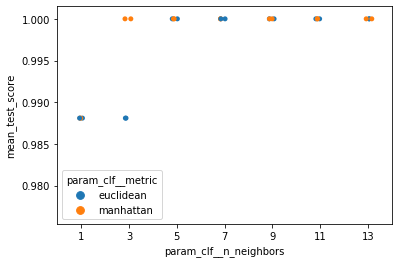

In [36]:
# la performance excepcional se debe a una configuracion particular? 
sns.stripplot(
    x="param_clf__n_neighbors", y="mean_test_score", hue="param_clf__metric", 
    data=cv_results)
    # strip agrega jitter
plt.show()

----------------------------------

## Bonus

>_Caching_ la matriz de distancias para reducir el tiempo de cómputo de KNN. Ver: 
>
>https://scikit-learn.org/stable/auto_examples/neighbors/plot_caching_nearest_neighbors.html